In [2]:
import os
import cv2
import numpy as np
import torch

data_dir = "Data"
classes = ["Earth", "Moon", "Jupiter", "Mars", "Mercury", "Neptune", "Pluto", "Uranus", "Venus"]

images = []
labels = []
# Modify the data loading part to ensure correct input shape
import torchvision.transforms as transforms

# Define transforms to preprocess the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((100, 100)),  # Resize images to 300x300
])

# Load and preprocess images, extract labels from filenames
images = []
labels = []

for img_file in os.listdir(data_dir):

    # if the file is .ds_store, ignore it
    if img_file == ".DS_Store":
        continue

    img_path = os.path.join(data_dir, img_file)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    img = transform(img)  # Apply transforms
    images.append(img)
    
    # check if image path contains either Earth, Moon
    # if yes, its label is 0 or 1
    # else its 2    
    if "earth" in img_file.lower():
        # show the earth image
        labels.append(0)
    elif "moon" in img_file.lower():
        labels.append(1)
    elif "jupiter" in img_file.lower():
        labels.append(2)
    elif "mars" in img_file.lower():
        labels.append(3)
    elif "mercury" in img_file.lower():
        labels.append(4)
    elif "neptune" in img_file.lower():
        labels.append(5)
    elif "pluto" in img_file.lower():
        labels.append(6)
    elif "uranus" in img_file.lower():
        labels.append(7)
    elif "venus" in img_file.lower():
        labels.append(8)
    else:
        print("ERROR - Image not labeled")
        
print(f"Loaded {len(images)} images with labels: {labels}")


KeyboardInterrupt: 

In [ ]:
# check if the size of labels is the same (so equal nmber of 0, 1 and 2)
print(len(labels))
# print the number of images per label
print("Number of images per label:")
print("Earth: ", labels.count(0))
print("Moon: ", labels.count(1))
print("Jupiter: ", labels.count(2))
print("Mars: ", labels.count(3))
print("Mercury: ", labels.count(4))
print("Neptune: ", labels.count(5))
print("Pluto: ", labels.count(6))
print("Uranus: ", labels.count(7))
print("Venus: ", labels.count(8))


# Convert images and labels to PyTorch tensors
images = torch.stack(images)
labels = torch.tensor(labels)


: 

In [3]:
# print the shape of the images and labels
print(" Images shape: ", images.shape)
print(" Labels shape: ", labels.shape)

 Images shape:  torch.Size([61594, 3, 100, 100])
 Labels shape:  torch.Size([61594])


In [4]:
# Step 2: Model Selection
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained MobileNetV2 model
base_model = models.mobilenet_v2()

for param in base_model.parameters():
    param.requires_grad = True

# Modify the classifier of the base model to fit our classification task
num_features = base_model.classifier[1].in_features
base_model.classifier = nn.Linear(num_features, len(classes))

# Define the complete model
model = base_model



In [5]:
# Step 3: Splitting Data
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images.clone().detach(), labels.clone().detach(), test_size=0.1)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train.clone().detach(), y_train.clone().detach(), test_size=0.2)



# Convert the data to PyTorch tensors
X_train = X_train.clone().detach().to(torch.float32)
X_val = X_val.clone().detach().to(torch.float32)
X_test = X_test.clone().detach().to(torch.float32)
y_train = y_train.clone().detach().to(torch.long)
y_val = y_val.clone().detach().to(torch.long)
y_test = y_test.clone().detach().to(torch.long)

# Create PyTorch datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


In [6]:
# # print the number of samples in the training, validation, and test sets
print("Number of samples in the training set: ", len(train_dataset))
print("Number of samples in the validation set: ", len(val_dataset))
print("Number of samples in the test set: ", len(test_dataset))

Number of samples in the training set:  44347
Number of samples in the validation set:  11087
Number of samples in the test set:  6160


In [7]:
# step 4: Training the Model

import torch.optim as optim

import logging

logging.basicConfig(filename='training.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define variables to keep track of the best model and the corresponding loss
best_val_loss = np.inf
patience = 0
max_patience = 2

# Train the model
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # print what batch we are on and the size of the batch
        # print the label of each image in the batch


        optimizer.zero_grad()
        outputs = model(inputs)

        # show what the model precited bs what the actual label is
        # log that
        logging.info(f"Batch size: {inputs.size(0)}")
        logging.info(f"Predictions: {outputs}")
        logging.info(f"Actual: {labels}")

    

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        # training loss
        running_loss += loss.item() * inputs.size(0)

    # Print training loss
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model if validation loss has decreased
        torch.save(model.state_dict(), 'best_model.pth')
        patience = 0
    else:
        patience += 1
        if patience > max_patience:
            print("Validation loss hasn't improved for too long. Stopping training.")
            break

    
    val_loss /= len(val_loader)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")


/home/felixyeung/github.com/felixyeungdev/comp3631-ros2-planets-dataset/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/2], Training Loss: 0.2861
Validation Loss: 0.0156, Validation Accuracy: 0.9959
Epoch [2/2], Training Loss: 0.0834
Validation Loss: 0.0020, Validation Accuracy: 0.9997


In [8]:
# Step 5: Model Evaluation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Print test loss and accuracy
test_loss /= len(test_loader.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0023, Test Accuracy: 0.9995


In [2]:
def predict_image(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (100, 100))  # Resize image to match model input size
    image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
    image = np.transpose(image, (2, 0, 1))  # Rearrange dimensions to (channels, height, width)
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    image = image.to(device)  # Move image to GPU if available

    

    # Perform inference
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
        predicted_class = classes[predicted]
    return predicted_class, confidence

# Example usage
# image_path = "Data/Earth (18).jpg"
# # show the image 
# import matplotlib.pyplot as plt
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.axis('off')
# plt.show()


# predicted_class, confidence = predict_image(image_path)
# print("Predicted Class:", predicted_class)
# print("Confidence:", confidence)

In [10]:
# save the model to disk
torch.save(model, "planet_working_twoepoch_1300images.pt")
print("Model saved to disk.")


Model saved to disk.


In [11]:
# load the model called "planet_model (1).pt"
model = torch.load("planet_model.pt")
model.eval()
print("Model loaded from disk.")

# 
predict_image("Data/Earth (1).jpg")



Model loaded from disk.


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

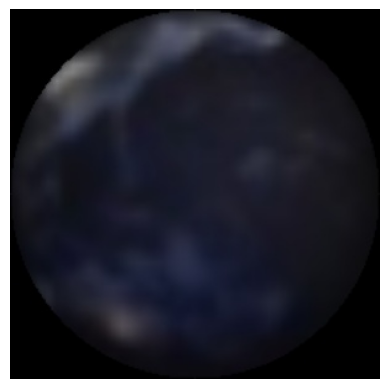

Predicted Class: Moon
Confidence: tensor([2.4152e+01, 5.4203e+01, 2.4034e-06, 2.1194e+01, 5.4501e-02, 1.5442e-04,
        3.9205e-01, 6.9458e-07, 4.7480e-03])


In [6]:
import torch
import os
import cv2
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("planet_working_twoepoch_1300images.pt", map_location=device)


# Example usage
image_path = "cropped_image.jpg"
# show the image 
import matplotlib.pyplot as plt
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()


predicted_class, confidence = predict_image(image_path)
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)